<a href="https://colab.research.google.com/github/aseelalzaben03/Arabic-Fake-news-detection-using-ARAB-BERT/blob/main/Graduation_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers sentencepiece
!pip install num2words
!pip install deep-translator
!pip install torch openpyxl
!pip install ydata-profiling
!pip install googletrans==4.0.0-rc1 tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=361943c3d622a37b03b351dd806bffecf6f1f86df819dd884728ee4b00edc883
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import libraries

In [2]:
import re
import os
import json
import pandas as pd
from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk.stem.arlstem import ARLSTem
from bs4 import BeautifulSoup
from num2words import num2words
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
import torch
from num2words import num2words
from googletrans import Translator
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from multiprocessing import Pool


## Loading Dataset

In [ ]:
#Load dataset
df = pd.read_excel('/content/balanced_data_correct (1).xlsx')
df.head()


,Unnamed: 0,is_fake,news
0,0,1,['الإدعاء\nخلال ظهورها مؤخرًا زعمت الفنانة سما...
1,1,0,تم اكتشاف فطر كانديدا أوريس المقاوم للأدوية من...
2,2,1,\n\nتداول مستخدمون على مواقع التواصل الاجتماعي...
3,3,1,['الإدعاء\nصورة منتشرة بشكل كبير جدا علي أنها ...
4,4,0,الغضب النقابي على مشروع قانون الإضراب فتصاعد. ...


In [ ]:
df.columns

Index(['Unnamed: 0', 'is_fake', 'news'], dtype='object')

In [ ]:
df=df.drop('Unnamed: 0', axis=1)
df.head()

,is_fake,news
0,1,['الإدعاء\nخلال ظهورها مؤخرًا زعمت الفنانة سما...
1,0,تم اكتشاف فطر كانديدا أوريس المقاوم للأدوية من...
2,1,\n\nتداول مستخدمون على مواقع التواصل الاجتماعي...
3,1,['الإدعاء\nصورة منتشرة بشكل كبير جدا علي أنها ...
4,0,الغضب النقابي على مشروع قانون الإضراب فتصاعد. ...


In [ ]:

# Generate the profile report
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

profile.to_notebook_iframe()

# Save the report to HTML
profile.to_file("my_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:24<00:00, 12.48s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df['is_fake'].value_counts()

,count
is_fake,
1,6059
0,6059


## Data Exploration Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

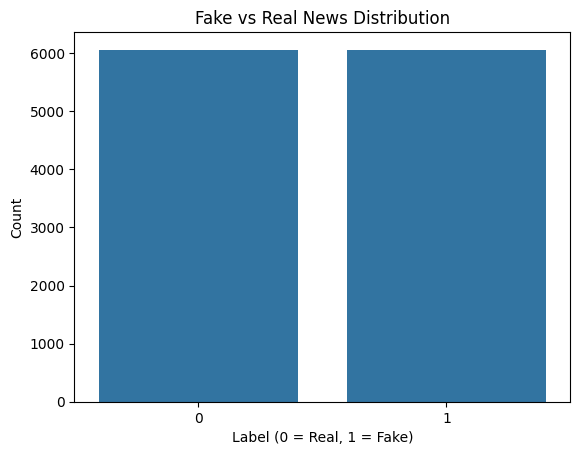

In [ ]:
# Class distribution
sns.countplot(x='is_fake', data=df)
plt.title("Fake vs Real News Distribution")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.show()

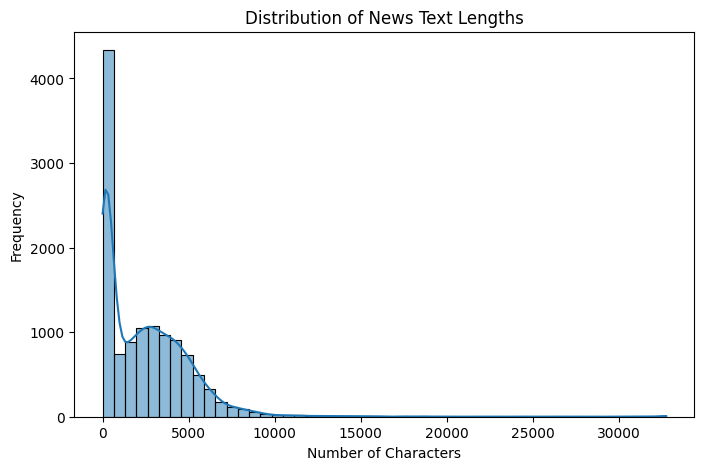

In [ ]:
# Text length distribution
df['text_length'] = df['news'].apply(lambda x: len(str(x)))
plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of News Text Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

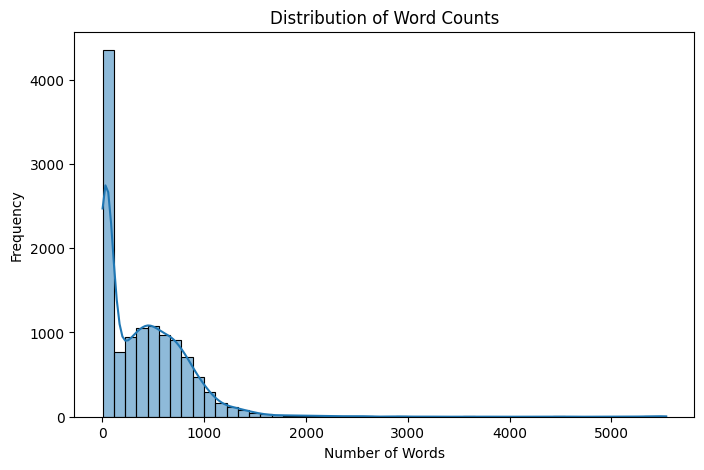

In [ ]:
# Word count distribution
df['word_count'] = df['news'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

## Preprocessing ( OLD )

**preprocessing pipline**:

Cleaning + Normalization

Summarization

    
Translation (for English words)

   
Cleaned Text (human readable)

Tokenization →  Used as input to model


In [ ]:

# Imports

import re
import torch
import pandas as pd
from num2words import num2words
from googletrans import Translator
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.notebook import tqdm


In [ ]:
# Setup

MAX_CHARS = 2000  # Texts longer than this will be summarized
translator = Translator()

# Load Arabic-compatible summarization model (mT5 trained on news)
sum_tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
sum_model = AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sum_model = sum_model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [ ]:
# Convert numeric digits to Arabic words (e.g., "2024" → "ألفان وأربعة وعشرون")
def convert_numbers_to_words(text):
    def replace_number(match):
        try:
            num = int(match.group())
            return num2words(num, lang='ar')
        except:
            return match.group()
    return re.sub(r'\d+', replace_number, text)

# Clean and normalize Arabic text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www.\S+", "", text)  # Remove URLs
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = convert_numbers_to_words(text)  # Convert digits to words
    text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)  # Remove non-Arabic characters
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    # Do not replace "ة" to preserve meaning

    text = re.sub(r'\s+', ' ', text).strip()
    return text



In [ ]:
# Translate English words to Arabic (for mixed Arabic-English texts)
def translate_english_to_arabic(text):
    words = text.split()
    english_words = list({word for word in words if re.search(r'[a-zA-Z]', word)})
    if not english_words:
        return text
    try:
        translations = translator.translate(english_words, src='en', dest='ar')
        translated_dict = {eng: trans.text for eng, trans in zip(english_words, translations)}
    except:
        translated_dict = {word: word for word in english_words}  # fallback to original words
    translated_words = [translated_dict.get(word, word) for word in words]
    return ' '.join(translated_words)

# Summarize long Arabic news using mT5 model
def summarize_text(text):
    # Skip summarization for very short or empty texts
    if not text or len(text.split()) <= 100:
        return text
    try:
        input_text = "summarize: " + text
        inputs = sum_tokenizer.encode(
            input_text,
            return_tensors="pt",
            truncation=True,
            max_length=512  # Input limit for the model
        ).to(device)

        # Generate summary with constraints
        summary_ids = sum_model.generate(
            inputs,
            max_length=200,   # Max length of generated summary in tokens
            min_length=30,    # Ensure minimum content is preserved
            length_penalty=1.0,
            num_beams=4,
            early_stopping=True
        )
        return sum_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    except Exception as e:
        print("Summarization error:", e)
        return text


In [ ]:
# Full preprocessing pipeline
def preprocess_pipeline(text):
    cleaned = clean_text(text)
    translated = translate_english_to_arabic(cleaned)
    summarized = summarize_text(translated)
    return summarized


In [ ]:
# Validate text: remove entries like "[]", "content ...", or meaningless ones
def is_valid(text):
    text = text.strip()
    return text and len(text) > 10 and not re.fullmatch(r'[\[\]{}()\-_.\s]*', text.lower()) and "content" not in text.lower()



In [ ]:
# Full preprocessing pipeline: clean → translate → summarize
def preprocess_pipeline(text):
    if not is_valid(text):
        return ""
    cleaned = clean_text(text)
    translated = translate_english_to_arabic(cleaned)
    summarized = summarize_text(translated)
    return summarized



In [ ]:
# Main function: read, process, and export
def main():
    # Load dataset
    df = pd.read_excel("/content/balanced_data_correct (1).xlsx")
    df = df.drop('Unnamed: 0', axis=1, errors='ignore')  # Drop index column if exists
    df["news"] = df["news"].fillna("").astype(str)

    print("Sample before preprocessing:")
    print(df["news"].head(3))

    # Apply preprocessing with progress bar
    tqdm.pandas()
    print("\nRunning preprocessing pipeline with progress bar...")
    df["cleaned_news"] = df["news"].progress_apply(preprocess_pipeline)

    print("\nSample after preprocessing:")
    print(df[["news", "cleaned_news"]].head(3))

    # Save cleaned dataset
    df.to_excel("cleaned_news_all_good.xlsx", index=False)
    print("Saved as cleaned_news_all_good.xlsx")

# Run the script
if __name__ == '__main__':
    main()

Sample before preprocessing:
0    ['الإدعاء\nخلال ظهورها مؤخرًا زعمت الفنانة سما...
1    تم اكتشاف فطر كانديدا أوريس المقاوم للأدوية من...
2    \n\nتداول مستخدمون على مواقع التواصل الاجتماعي...
Name: news, dtype: object

Running preprocessing pipeline with progress bar...


  0%|          | 0/12118 [00:00<?, ?it/s]


Sample after preprocessing:
                                                news  \
0  ['الإدعاء\nخلال ظهورها مؤخرًا زعمت الفنانة سما...   
1  تم اكتشاف فطر كانديدا أوريس المقاوم للأدوية من...   
2  \n\nتداول مستخدمون على مواقع التواصل الاجتماعي...   

                                        cleaned_news  
0  الادعاء nخلال ظهورها موخرًا زعمت الفنانة سماح ...  
1  تم اكتشاف فطر كانديدا اوريس المقاوم للادوية من...  
2  تداول مستخدمون علي مواقع التواصل الاجتماعي موخ...  
Saved as cleaned_news_all_good.xlsx


## Tokenization

In [ ]:
!pip install --upgrade transformers


In [ ]:
#Import libraries
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset

In [ ]:
df_cleaned = pd.read_excel("/content/cleaned_news_all_good.xlsx")
df_cleaned.head()

,is_fake,news,cleaned_news
0,1,['الإدعاء\nخلال ظهورها مؤخرًا زعمت الفنانة سما...,الادعاء nخلال ظهورها موخرًا زعمت الفنانة سماح ...
1,0,تم اكتشاف فطر كانديدا أوريس المقاوم للأدوية من...,تم اكتشاف فطر كانديدا اوريس المقاوم للادوية من...
2,1,\n\nتداول مستخدمون على مواقع التواصل الاجتماعي...,تداول مستخدمون علي مواقع التواصل الاجتماعي موخ...
3,1,['الإدعاء\nصورة منتشرة بشكل كبير جدا علي أنها ...,الادعاء nصورة منتشرة بشكل كبير جدا علي انها ان...
4,0,الغضب النقابي على مشروع قانون الإضراب فتصاعد. ...,اعلن الاتحاد المغربي للشغل انه قرر عقد ندوة صح...


In [ ]:
df_cleaned.columns

Index(['is_fake', 'news', 'cleaned_news'], dtype='object')

In [ ]:
df_cleaned=df_cleaned.drop('news', axis=1)
df_cleaned = df_cleaned.dropna(subset=['cleaned_news'])  # Drop any empty news rows

df_cleaned.head()

,is_fake,cleaned_news
0,1,الادعاء nخلال ظهورها موخرًا زعمت الفنانة سماح ...
1,0,تم اكتشاف فطر كانديدا اوريس المقاوم للادوية من...
2,1,تداول مستخدمون علي مواقع التواصل الاجتماعي موخ...
3,1,الادعاء nصورة منتشرة بشكل كبير جدا علي انها ان...
4,0,اعلن الاتحاد المغربي للشغل انه قرر عقد ندوة صح...


In [ ]:
from transformers import AutoTokenizer

# Load Arabic BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")


In [ ]:
# Apply tokenizer to a list of texts
def tokenize_texts(texts, max_length=512):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"  # PyTorch tensors
    )


In [ ]:
# Example usage on cleaned dataframe
def run_tokenization():
    df = pd.read_excel("/content/cleaned_news_all_good.xlsx")
    df["cleaned_news"] = df["cleaned_news"].fillna("")

    print("Tokenizing cleaned text...")
    tokenized = tokenize_texts(df["cleaned_news"])

    # tokenized is a dict: {'input_ids': ..., 'attention_mask': ...}
    print("Example input_ids:")
    print(tokenized["input_ids"][0])

    return tokenized, df


In [ ]:
# Run
tokenized_data, df = run_tokenization()


Tokenizing cleaned text...
Example input_ids:
tensor([    2, 11511,    83,  6362,   182, 35234,     1, 42088,  7705, 26305,
        23126,  1114, 12783,   310, 14607,   485,  5064,  5582,  1292,     1,
          103,  1668,  1948,  5955,   348, 21702,   349,   732, 10147,   497,
        49600,  3846,  1175, 14538,    83, 29259,   194, 38716,   338, 12783,
         2252,  1507,   311,  4094, 53407,  6196, 56093,   225,  2089,   408,
          305,  4426,   485,   963, 13268,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    

## Modeling

## Step 1: Split + Dataset Class

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

In [ ]:
# Tokenization function
def tokenize_texts(texts, max_length=512):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

In [ ]:
# Split data into train/val/test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["cleaned_news"], df["is_fake"], test_size=0.2, stratify=df["is_fake"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)


In [ ]:


# Custom Dataset class
class ArabicNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            texts.tolist(),
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels.tolist())

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create Dataset instances
train_dataset = ArabicNewsDataset(train_texts, train_labels, tokenizer)
val_dataset = ArabicNewsDataset(val_texts, val_labels, tokenizer)
test_dataset = ArabicNewsDataset(test_texts, test_labels, tokenizer)


## Step 2: DataLoaders, Model, Training Loop

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# DataLoaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
# Load Arabic BERT with classification head (2 classes)
model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv02",
    num_labels=2
).to(device)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


In [ ]:
# Training function
def train(model, train_loader, val_loader):
    model.train()
    for epoch in range(num_epochs):
        print(f"\n Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0
        model.train()
        for batch in tqdm(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        print(f" Training Loss: {total_loss / len(train_loader):.4f}")

        # Validation after each epoch
        evaluate(model, val_loader, mode="Validation")




In [ ]:
# Evaluation function
def evaluate(model, data_loader, mode="Test"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            labels = batch["labels"].to(device)
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"{mode} Accuracy: {acc:.4f}")
    print(f"{mode} Classification Report:\n{classification_report(all_labels, all_preds)}")

In [ ]:
# Run training
train(model, train_loader, val_loader)



 Epoch 1/3


100%|██████████| 606/606 [04:00<00:00,  2.51it/s]


 Training Loss: 0.0457
Validation Accuracy: 0.9802
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       606
           1       0.97      0.99      0.98       606

    accuracy                           0.98      1212
   macro avg       0.98      0.98      0.98      1212
weighted avg       0.98      0.98      0.98      1212


 Epoch 2/3


100%|██████████| 606/606 [04:06<00:00,  2.45it/s]


 Training Loss: 0.0263
Validation Accuracy: 0.9802
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       606
           1       0.98      0.98      0.98       606

    accuracy                           0.98      1212
   macro avg       0.98      0.98      0.98      1212
weighted avg       0.98      0.98      0.98      1212


 Epoch 3/3


100%|██████████| 606/606 [04:07<00:00,  2.45it/s]


 Training Loss: 0.0209
Validation Accuracy: 0.9802
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       606
           1       0.98      0.98      0.98       606

    accuracy                           0.98      1212
   macro avg       0.98      0.98      0.98      1212
weighted avg       0.98      0.98      0.98      1212



In [ ]:
evaluate(model, test_loader, mode="Test")


Test Accuracy: 0.9818
Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       606
           1       0.98      0.99      0.98       606

    accuracy                           0.98      1212
   macro avg       0.98      0.98      0.98      1212
weighted avg       0.98      0.98      0.98      1212



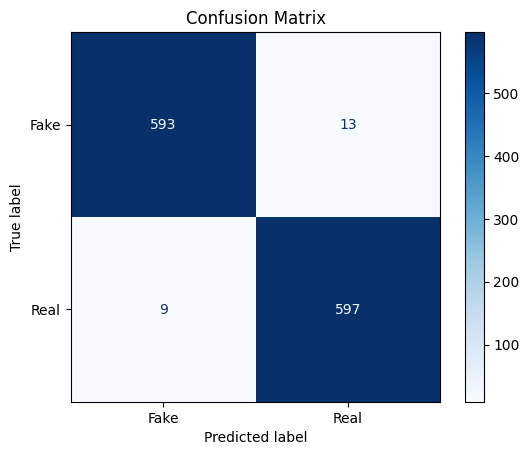

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Create confusion matrix and plot it with blue color map
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save_pretrained("arabert-fake-news")
tokenizer.save_pretrained("arabert-fake-news")


('arabert-fake-news/tokenizer_config.json',
 'arabert-fake-news/special_tokens_map.json',
 'arabert-fake-news/vocab.txt',
 'arabert-fake-news/added_tokens.json',
 'arabert-fake-news/tokenizer.json')

In [ ]:
# to use later
#from transformers import AutoModelForSequenceClassification, AutoTokenizer

#model = AutoModelForSequenceClassification.from_pretrained("arabert-fake-news")
#tokenizer = AutoTokenizer.from_pretrained("arabert-fake-news")


In [ ]:
def predict(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    return "Real" if pred == 1 else "Fake", probs[0][pred].item()


In [ ]:
sample_text = "الخبر الذي تم تداوله عبر وسائل الإعلام يحتوي على معلومات غير مؤكدة."
label, confidence = predict(sample_text, model, tokenizer)

print(f"Prediction: {label} (Confidence: {confidence:.2f})")


Prediction: Real (Confidence: 0.98)


In [ ]:
text1 = "أعلنت وزارة الصحة عن اكتشاف علاج جديد فعال لفيروس كورونا بدون الحاجة إلى لقاح."
label1, conf1 = predict(text1, model, tokenizer)
print(f"Prediction: {label1} (Confidence: {conf1:.2f})")


Prediction: Fake (Confidence: 1.00)


In [ ]:
text2 = "تم تداول خبر عن وجود زلزال قوي في مدينة الرياض اليوم صباحاً، ولم يتم تأكيده من الجهات الرسمية."
label2, conf2 = predict(text2, model, tokenizer)
print(f"Prediction: {label2} (Confidence: {conf2:.2f})")


Prediction: Real (Confidence: 0.98)


In [ ]:
text3 = "رئيس الوزراء يؤكد في مؤتمر صحفي على أهمية تعزيز الاقتصاد المحلي ودعم المشاريع الصغيرة."
label3, conf3 = predict(text3, model, tokenizer)
print(f"Prediction: {label3} (Confidence: {conf3:.2f})")


Prediction: Fake (Confidence: 0.74)


In [ ]:
text4 = "شركة آبل تعلن عن إطلاق هاتفها الجديد بتقنية تسمح بالشحن من خلال الهواء."
label4, conf4 = predict(text4, model, tokenizer)
print(f"Prediction: {label4} (Confidence: {conf4:.2f})")


Prediction: Fake (Confidence: 0.91)


In [ ]:
text5 = "السلطات الأردنية تنفي إشاعات إغلاق الحدود مع السعودية بسبب الأحداث الأخيرة."
label5, conf5 = predict(text5, model, tokenizer)
print(f"Prediction: {label5} (Confidence: {conf5:.2f})")


Prediction: Real (Confidence: 0.93)
